In [22]:
from fastai.vision.all import *

In [36]:
path = 'dataset'
fnames = get_image_files(path)
def label_func(x): return x.parent.name

In [37]:
dls = ImageDataLoaders.from_path_func(path, fnames, label_func, number_workers=0)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


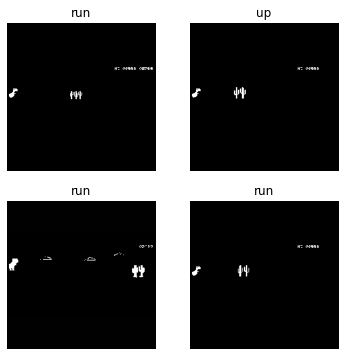

In [38]:
dls.valid.show_batch(max_n=4, nrows=2)

last image is caused by game background transition

In [45]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

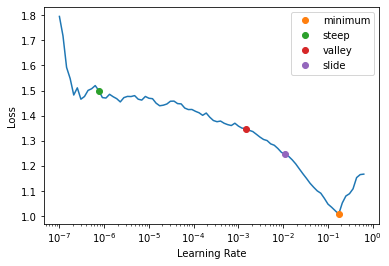

In [43]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [46]:
learn.fine_tune(5, base_lr=10e-03)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.815362,0.634230,0.079661,0.920339,02:46


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.264417,0.512542,0.157627,0.842373,03:34
1,0.240590,0.193559,0.098305,0.901695,03:13
2,0.204996,0.210677,0.081356,0.918644,02:55
3,0.157778,0.215208,0.093220,0.906780,03:00
4,0.123503,0.197369,0.079661,0.920339,02:57


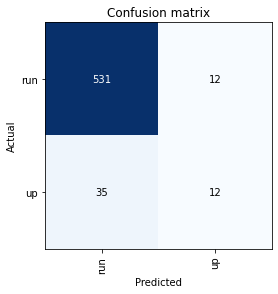

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [53]:
learn.export(os.path.abspath('models/v1.pkl'))